<a href="https://colab.research.google.com/github/nikhilpavithran/Practical-Deep-Learning-Book/blob/master/Anam_Feb4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://stackoverflow.com/questions/52128744/how-to-ensure-all-pytorch-code-fully-utilises-gpu-on-google-colab

import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding =1,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())


        self.ext_conv2 = nn.Sequential(
             nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                dilation=dilation,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)
        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)
        # Add main and extension branches
        out = main + ext
        return self.out_activation(out)

class AnamNet(nn.Module):

    def __init__(self):

        super(AnamNet, self).__init__()

        # Conv block 1 - Down 1
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 1
        self.bottleneck1 = Bottleneck(64)


        # Conv block 2 - Down 2
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 2
        self.bottleneck2 = Bottleneck(128)

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 3
        self.bottleneck3 = Bottleneck(256)

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)

        self.bottleneck4 = Bottleneck(256)
        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        
        self.bottleneck5 =Bottleneck(256)    
        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.bottleneck6 = Bottleneck(128)
        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Final output
        self.conv_final = nn.Conv2d(in_channels=64, out_channels=3,
                                    kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        
        #print('inputTensor', x.shape)
        #---------------------------------------------------------------------
        # Down 1
        x = self.conv1_block(x)
        #print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        #print('after pool1', x.shape)
        #--------------------------------------------------------------------
        x = self.bottleneck1(x)
        #print('after bnck1', x.shape)
        # Down 2
        x = self.conv2_block(x)
        #print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        #print('after pool2', x.shape)
        #-------------------------------------------------------------------
        x = self.bottleneck2(x)
        #print('after bnck2', x.shape)
        # Down 3
        x = self.conv3_block(x)
        #print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        #print('after pool3', x.shape)
        #------------------------------------------------------------------
        x = self.bottleneck3(x)
        #print('after bnck3', x.shape)
        # Down 4
        x = self.conv4_block(x)
        #print('after conv4', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        #print('after pool4', x.shape)
        #----------------------------------------------------------------        
        # Up 1
        x = self.up_1(x)
        #print('after  up_1', x.shape)
        x = self.bottleneck4(x)
        #print('after bnck4', x.shape)
        lower = int((conv4_dim - x.shape[2]) / 2)
        upper = int(conv4_dim - lower)
        conv4_out_modified = conv4_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv4_out_modified], dim=1)
        #print('after cat_1',x.shape)        
        x = self.conv_up_1(x)
        #print('after conv1', x.shape)
        #-----------------------------------------------------------------
        # Up 2
        x = self.up_2(x)
        #print('after  up_2', x.shape)
        x = self.bottleneck5(x)
        #print('after bnck5', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        #print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        #print('after conv2', x.shape)
        #----------------------------------------------------------------
        # Up 3
        x = self.up_3(x)
        #print('after  up_3', x.shape)
        x = self.bottleneck6(x)
        #print('after bnck6', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        #print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        #print('after conv3', x.shape)
        #----------------------------------------------------------------
        # Up 4
        x = self.up_4(x)
        #print('after  up_3', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        #print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        #print('after conv4', x.shape)
        # Final output
        x = self.conv_final(x)
        #print('Finaloutshape',x.shape)
        #-----------------------------------------------------------------
        return x

    
if __name__ == "__main__":
    x= torch.rand(1,1,512,512)
    net=AnamNet()
    yy=net(x)
    print('In Shape :', x.shape)
    print('Out Shape :', yy.shape)

In Shape : torch.Size([1, 1, 512, 512])
Out Shape : torch.Size([1, 3, 512, 512])


In [ ]:
!gdown --id 1a9mPUkf3AMNHFqUZQKWFDWZv4LYqL_Bg
!gdown --id 1vR9JTDWW8q3v3R9Z1fAtjRYGO-YGIj9v

Downloading...
From: https://drive.google.com/uc?id=1a9mPUkf3AMNHFqUZQKWFDWZv4LYqL_Bg
To: /content/train_image.npy
63.9MB [00:00, 124MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1vR9JTDWW8q3v3R9Z1fAtjRYGO-YGIj9v
To: /content/train_label.npy
52.4MB [00:00, 144MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data_arr_im = np.loadtxt("train_image.npy",dtype=int)
inp1 = data_arr_im.reshape(data_arr_im.shape[0], data_arr_im.shape[1] // 100, 100) 

data_arr_lab = np.loadtxt("train_label.npy",dtype=int)
lab1 = data_arr_lab.reshape(data_arr_lab.shape[0], data_arr_lab.shape[1] // 100, 100) 

print("inp1.shape  : ", inp1.shape)
print("lab1.shape  : ", inp1.shape)

inp  = inp1
lab  = lab1

traininp =np.reshape( np.transpose(inp,(2,0,1)),(100,512,512,1))
trainlab =np.reshape( np.transpose(lab,(2,0,1)),(100,512,512,1))      

print("traininp.shape  : ", traininp.shape)
print("trainlab.shape  : ", traininp.shape)

inp1.shape  :  (512, 512, 100)
lab1.shape  :  (512, 512, 100)
traininp.shape  :  (100, 512, 512, 1)
trainlab.shape  :  (100, 512, 512, 1)


In [ ]:
#Config
class Config :    
    def __init__(self):
        self.gpu       = True
        self.gpuid     = 1
        self.batchsize = 5
        self.epochs    = 100

import torch
from torch.utils.data import Dataset

#myDataset
class myDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.X = images
        self.Y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        datax = self.X[i, :]
        datay = self.Y[i, :]                     
        if self.transforms:
            datax = self.transforms(datax).float()  
            datay = torch.LongTensor(datay)            
        return datax, datay     

# Create directory for saving model
import os,time
from datetime import datetime

print ('*******************************************************')
start_time=time.time()
saveDir='savedModels/'
cwd=os.getcwd()
directory=saveDir+datetime.now().strftime("%d%b_%I%M%P_")+'model'
print('Model will be saved to  :', directory)

if not os.path.exists(directory):
    os.makedirs(directory)


*******************************************************
Model will be saved to  : savedModels/03Feb_0541pm_model


In [ ]:
import os,time
import sklearn.metrics as metrics
import scipy.io
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import tqdm
import torch.nn as nn
from datetime import datetime
#from config import Config
#from mydataset import myDataset
#from anamnet import AnamNet
import torch.optim as optim
from torch.optim import lr_scheduler

config  = Config()
transform = transforms.Compose([transforms.ToTensor(),
            ])

# make the data iterator for training data
train_data = myDataset(traininp,trainlab, transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=config.batchsize, shuffle=True, num_workers=2)

#
labels = trainlab.flatten()
class_count = np.bincount(labels, minlength=3)
propensity_score = class_count/labels.size ###
class_weights = 1 / propensity_score #########


In [ ]:
 print(class_weights)
 class_weights = torch.cuda.FloatTensor(class_weights) #.cuda()

tensor([ 1.3655, 14.2444,  5.0636], device='cuda:0')


----------------------------------------------------------


20it [00:13,  1.43it/s]

Training - Epoch 1/100, loss:1.0332 



20it [00:14,  1.41it/s]

Training - Epoch 2/100, loss:0.9550 



20it [00:14,  1.38it/s]

Training - Epoch 3/100, loss:0.9136 



20it [00:14,  1.40it/s]

Training - Epoch 4/100, loss:0.8973 



20it [00:14,  1.42it/s]

Training - Epoch 5/100, loss:0.8894 



20it [00:14,  1.43it/s]

Training - Epoch 6/100, loss:0.8821 



20it [00:13,  1.43it/s]

Training - Epoch 7/100, loss:0.8847 



20it [00:14,  1.41it/s]

Training - Epoch 8/100, loss:0.8766 



20it [00:14,  1.41it/s]

Training - Epoch 9/100, loss:0.8597 



20it [00:14,  1.41it/s]

Training - Epoch 10/100, loss:0.8567 



20it [00:14,  1.41it/s]

Training - Epoch 11/100, loss:0.8612 



20it [00:14,  1.42it/s]

Training - Epoch 12/100, loss:0.8513 



20it [00:14,  1.42it/s]

Training - Epoch 13/100, loss:0.8591 



20it [00:14,  1.41it/s]

Training - Epoch 14/100, loss:0.8461 



20it [00:14,  1.41it/s]

Training - Epoch 15/100, loss:0.8415 



20it [00:14,  1.41it/s]

Training - Epoch 16/100, loss:0.8317 



20it [00:14,  1.42it/s]

Training - Epoch 17/100, loss:0.8222 



20it [00:14,  1.41it/s]

Training - Epoch 18/100, loss:0.8370 



20it [00:14,  1.41it/s]

Training - Epoch 19/100, loss:0.8145 



20it [00:14,  1.41it/s]

Training - Epoch 20/100, loss:0.8141 



20it [00:14,  1.41it/s]

Training - Epoch 21/100, loss:0.7924 



20it [00:14,  1.41it/s]

Training - Epoch 22/100, loss:0.7999 



20it [00:14,  1.41it/s]

Training - Epoch 23/100, loss:0.7644 



20it [00:14,  1.41it/s]

Training - Epoch 24/100, loss:0.7526 



20it [00:14,  1.41it/s]

Training - Epoch 25/100, loss:0.7518 



20it [00:14,  1.41it/s]

Training - Epoch 26/100, loss:0.7484 



20it [00:14,  1.41it/s]

Training - Epoch 27/100, loss:0.7275 



20it [00:14,  1.41it/s]

Training - Epoch 28/100, loss:0.7057 



20it [00:14,  1.42it/s]

Training - Epoch 29/100, loss:0.7145 



20it [00:14,  1.41it/s]

Training - Epoch 30/100, loss:0.6766 



20it [00:14,  1.41it/s]

Training - Epoch 31/100, loss:0.6593 



20it [00:14,  1.42it/s]

Training - Epoch 32/100, loss:0.6305 



20it [00:14,  1.41it/s]

Training - Epoch 33/100, loss:0.6334 



20it [00:14,  1.41it/s]

Training - Epoch 34/100, loss:0.5887 



20it [00:14,  1.42it/s]

Training - Epoch 35/100, loss:0.5700 



20it [00:14,  1.42it/s]

Training - Epoch 36/100, loss:0.5615 



20it [00:14,  1.42it/s]

Training - Epoch 37/100, loss:0.5481 



20it [00:14,  1.42it/s]

Training - Epoch 38/100, loss:0.5421 



20it [00:14,  1.41it/s]

Training - Epoch 39/100, loss:0.5389 



20it [00:14,  1.41it/s]

Training - Epoch 40/100, loss:0.5399 



20it [00:14,  1.41it/s]

Training - Epoch 41/100, loss:0.5344 



20it [00:14,  1.41it/s]

Training - Epoch 42/100, loss:0.5350 



20it [00:14,  1.41it/s]

Training - Epoch 43/100, loss:0.5263 



20it [00:14,  1.41it/s]

Training - Epoch 44/100, loss:0.5099 



20it [00:14,  1.42it/s]

Training - Epoch 45/100, loss:0.5044 



20it [00:14,  1.42it/s]

Training - Epoch 46/100, loss:0.4979 



20it [00:14,  1.42it/s]

Training - Epoch 47/100, loss:0.5159 



20it [00:14,  1.41it/s]

Training - Epoch 48/100, loss:0.4966 



20it [00:14,  1.42it/s]

Training - Epoch 49/100, loss:0.4922 



20it [00:14,  1.42it/s]

Training - Epoch 50/100, loss:0.4960 



20it [00:14,  1.41it/s]

Training - Epoch 51/100, loss:0.4915 



20it [00:14,  1.41it/s]

Training - Epoch 52/100, loss:0.4764 



20it [00:14,  1.41it/s]

Training - Epoch 53/100, loss:0.4753 



20it [00:14,  1.41it/s]

Training - Epoch 54/100, loss:0.4834 



20it [00:14,  1.41it/s]

Training - Epoch 55/100, loss:0.4715 



20it [00:14,  1.41it/s]

Training - Epoch 56/100, loss:0.4624 



20it [00:14,  1.41it/s]

Training - Epoch 57/100, loss:0.4617 



20it [00:14,  1.41it/s]

Training - Epoch 58/100, loss:0.4480 



20it [00:14,  1.41it/s]

Training - Epoch 59/100, loss:0.4542 



20it [00:14,  1.41it/s]

Training - Epoch 60/100, loss:0.4419 



20it [00:14,  1.41it/s]

Training - Epoch 61/100, loss:0.4372 



20it [00:14,  1.41it/s]

Training - Epoch 62/100, loss:0.4444 



20it [00:14,  1.41it/s]

Training - Epoch 63/100, loss:0.4334 



20it [00:14,  1.41it/s]

Training - Epoch 64/100, loss:0.4240 



20it [00:14,  1.41it/s]

Training - Epoch 65/100, loss:0.4103 



20it [00:14,  1.41it/s]

Training - Epoch 66/100, loss:0.4183 



20it [00:14,  1.41it/s]

Training - Epoch 67/100, loss:0.3934 



20it [00:14,  1.41it/s]

Training - Epoch 68/100, loss:0.3996 



20it [00:14,  1.41it/s]

Training - Epoch 69/100, loss:0.4172 



20it [00:14,  1.41it/s]

Training - Epoch 70/100, loss:0.4069 



20it [00:14,  1.41it/s]

Training - Epoch 71/100, loss:0.4069 



20it [00:14,  1.41it/s]

Training - Epoch 72/100, loss:0.3998 



20it [00:14,  1.41it/s]

Training - Epoch 73/100, loss:0.3855 



20it [00:14,  1.42it/s]

Training - Epoch 74/100, loss:0.3962 



20it [00:14,  1.41it/s]

Training - Epoch 75/100, loss:0.3929 



20it [00:14,  1.41it/s]

Training - Epoch 76/100, loss:0.3942 



20it [00:14,  1.41it/s]

Training - Epoch 77/100, loss:0.4009 



20it [00:14,  1.41it/s]

Training - Epoch 78/100, loss:0.3894 



20it [00:14,  1.41it/s]

Training - Epoch 79/100, loss:0.3898 



20it [00:14,  1.41it/s]

Training - Epoch 80/100, loss:0.3893 



20it [00:14,  1.41it/s]

Training - Epoch 81/100, loss:0.3965 



20it [00:14,  1.41it/s]

Training - Epoch 82/100, loss:0.3868 



20it [00:14,  1.41it/s]

Training - Epoch 83/100, loss:0.3921 



20it [00:14,  1.41it/s]

Training - Epoch 84/100, loss:0.3915 



20it [00:14,  1.41it/s]

Training - Epoch 85/100, loss:0.3933 



20it [00:14,  1.41it/s]

Training - Epoch 86/100, loss:0.3920 



20it [00:14,  1.41it/s]

Training - Epoch 87/100, loss:0.4012 



20it [00:14,  1.41it/s]

Training - Epoch 88/100, loss:0.3922 



20it [00:14,  1.41it/s]

Training - Epoch 89/100, loss:0.3816 



20it [00:14,  1.41it/s]

Training - Epoch 90/100, loss:0.3884 



20it [00:14,  1.41it/s]

Training - Epoch 91/100, loss:0.3880 



20it [00:14,  1.41it/s]

Training - Epoch 92/100, loss:0.3969 



20it [00:14,  1.41it/s]

Training - Epoch 93/100, loss:0.3867 



20it [00:14,  1.41it/s]

Training - Epoch 94/100, loss:0.3811 



20it [00:14,  1.41it/s]

Training - Epoch 95/100, loss:0.3814 



20it [00:14,  1.41it/s]

Training - Epoch 96/100, loss:0.3901 



20it [00:14,  1.41it/s]

Training - Epoch 97/100, loss:0.3755 



20it [00:14,  1.41it/s]

Training - Epoch 98/100, loss:0.3743 



20it [00:14,  1.41it/s]

Training - Epoch 99/100, loss:0.3892 



20it [00:14,  1.41it/s]


Training - Epoch 100/100, loss:0.3819 


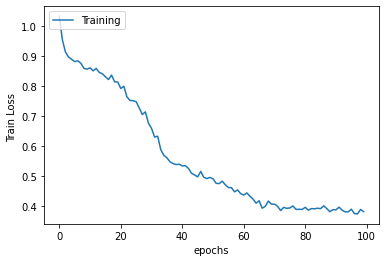

In [ ]:
print('----------------------------------------------------------')
#%%
# Create the object for the network

if config.gpu == True:    
    net = AnamNet()
    net.cuda() #config.gpuid
    #class_weights = torch.FloatTensor(class_weights).cuda() #config.gpuid    
    class_weights = torch.cuda.FloatTensor(class_weights)
else:
   net = AnamNet()
   
# Define the optimizer
optimizer = optim.Adam(net.parameters(),lr=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=33, gamma=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()


# Iterate over the training dataset
train_loss = []
sens = []
spec = []
acc  = []
img_rows = 512
img_cols = 512
numImgs  = 5 # should be same as mini batch size

for j in range(config.epochs):  
    # Start epochs   
    runtrainloss = 0
    net.train() 
    for i,data in tqdm.tqdm(enumerate(trainloader)): 
        # start iterations
        images,trainLabels = Variable(data[0]),Variable(data[1])
        
        # ckeck if gpu is available
        if config.gpu == True:
            images  = images.cuda( )#config.gpuid
            trainLabels = trainLabels.cuda() #config.gpuid
                    
        # make forward pass      
        output = net(images)
       
        #compute loss
        loss   = criterion(output, trainLabels.squeeze())        
                
        # make gradients zero
        optimizer.zero_grad()
        
        # back propagate
        loss.backward()
        
        # Accumulate loss for current minibatch
        runtrainloss += loss.item()
        
        
        # update the parameters
        optimizer.step()       
        
       
    # print loss after every epoch
    
    print('Training - Epoch {}/{}, loss:{:.4f} '.format(j+1, config.epochs, runtrainloss/len(trainloader)))
    train_loss.append(runtrainloss/len(trainloader))
    
       
    # Take a step for scheduler
    scheduler.step()
    
    
    #save the model  
    torch.save(net.state_dict(),os.path.join(directory,"AnamNet_" + str(j+1) +"_model.pth"))
    	    

# Save the train stats
np.save(directory+'/trnloss.npy',np.array(train_loss) )


# plot the training loss
x = range(config.epochs)
plt.figure()
plt.plot(x,train_loss,label='Training')
plt.xlabel('epochs')
plt.ylabel('Train Loss ') 
plt.legend(loc="upper left")  
plt.show()